# Module 3 Code

## Importing the data

This is largely reused from Week 2 assignment.

Have added in importing the movie information data, including adding column names for easier plotting.

TODOs:
 * Take weighted (by distance) averages to obtain predicted weightings
 * Find out best practices for how to impute and/or handle missing values. 

In [49]:
from collections import defaultdict
from datetime import datetime
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

USERS_DATA_FILE = os.path.join("..", "data", "u.data")
ITEMS_DATA_FILE = os.path.join("..", "data", "u.item")

N_USERS, N_MOVIES = 943, 1682

users = pd.read_csv(USERS_DATA_FILE,
                    header = None,
                    sep = "\t",
                    names = ["user", "movie", "rating", "timestamp"],
                    dtype = {"user": int,
                             "movie": int,
                             "rating": int,
                             "timestamp": int})

users.timestamp = pd.to_datetime(users.timestamp, unit = "s")

genres = ["Unknown_genre", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime",
          "Documentary", "Drama", "Fantasy", "Film_Noir", "Horror", "Musical",
          "Mystery", "Romance", "Sci_Fi", "Thriller", "War", "Western"]

column_names = ["movie_id", "movie_title", "video_release", "empty", "URL"] + genres

items = pd.read_csv(ITEMS_DATA_FILE,
            sep = "|",
            #index_col = False,
            encoding = "latin-1",
            header = None,
            names = column_names)

items = items.drop(columns=["empty"])

items[['movie_title', 'year']] = items['movie_title'].str.extract(r'^(.*)\s\((\d{4})\)$')
items.year = items.year.astype(float)

# Create 2 data structures for the data (dictionary-based and array-based)
data = defaultdict(dict)
data_filled = np.full((N_USERS, N_MOVIES),
                      np.nan)

with open(USERS_DATA_FILE, newline='', encoding='utf-8') as file:
    for line in file:
        fields = line.strip().split("\t")
        user_data = data[int(fields[0])]
        user_data[int(fields[1])] = int(fields[2])

        data_filled[int(fields[0]) - 1, int(fields[1]) - 1] = int(fields[2])

data_filled_zeros = np.nan_to_num(data_filled)
data_filled_zeros_normed = data_filled_zeros - data_filled_zeros.mean(axis = 1)[:, None]

# Create row averages for movies rated
user_means = dict()
data_normed = defaultdict(dict)
for user in data.keys():
    user_ratings = data[user].values()
    if len(user_ratings) > 0:
        user_means[user] = sum(user_ratings) / len(user_ratings)
    else:
        user_means[user] = 0
    for movie in data[user].keys():
        data_normed[user][movie] = data[user][movie] - user_means[user]

## Exploring the data

I've produced a few visualizations to explore the data
1. 
Based on the labels provide, drama and comedy are the two most common types of movies in the movie dataset. Fantasy, Film Noir and Western are the least represented.


### Distribution of ratings

Text(0, 0.5, 'Number of Ratings')

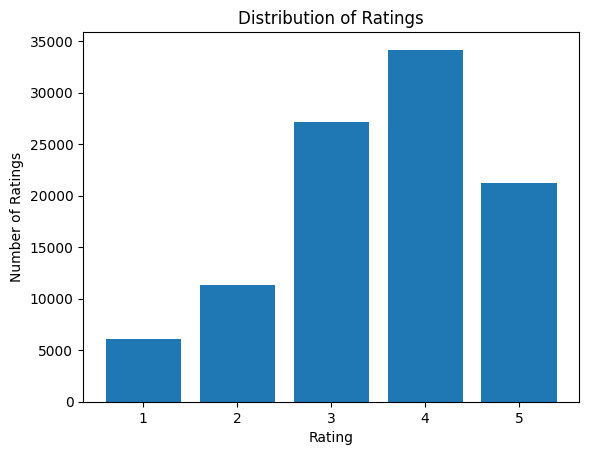

In [50]:
plt.bar(users.rating.value_counts().index, users.rating.value_counts().values)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")

Text(0.5, 1.0, 'Mean Rating by Genre')

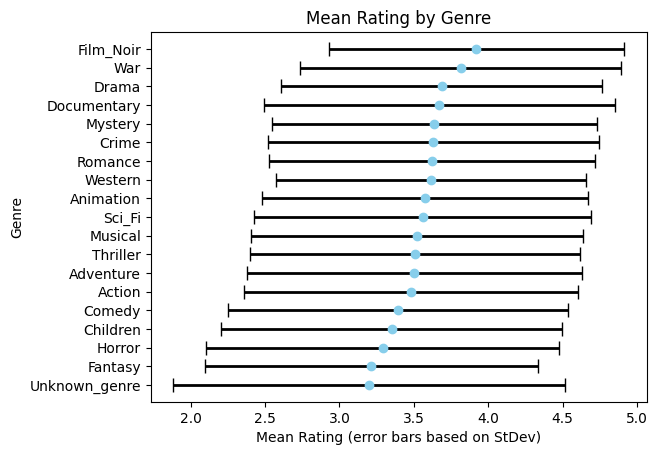

In [51]:
merged_data = users.merge(items,
                          how="left",
                          left_on = "movie",
                          right_on="movie_id")

b = merged_data.melt(id_vars=["movie_title", "rating"],
                     value_vars = genres,
                     var_name = "genre",
                     value_name = "genre_pres")

b = b[b["genre_pres"] == 1].drop(columns = ["genre_pres"])
b = b.groupby("genre").agg({"rating": ["mean", "std"]})
b.columns = ['rating_mean', 'rating_std']
b = b.sort_values("rating_mean")

plt.errorbar(b["rating_mean"], b.index, xerr = b["rating_std"], fmt='o', 
            capsize=5, color='skyblue', ecolor='black', elinewidth=2)

plt.xlabel('Mean Rating (error bars based on StDev)')
plt.ylabel('Genre')
plt.title("Mean Rating by Genre")

### Ratings by Genre

Text(0.5, 1.0, 'Movies by Genre in DB')

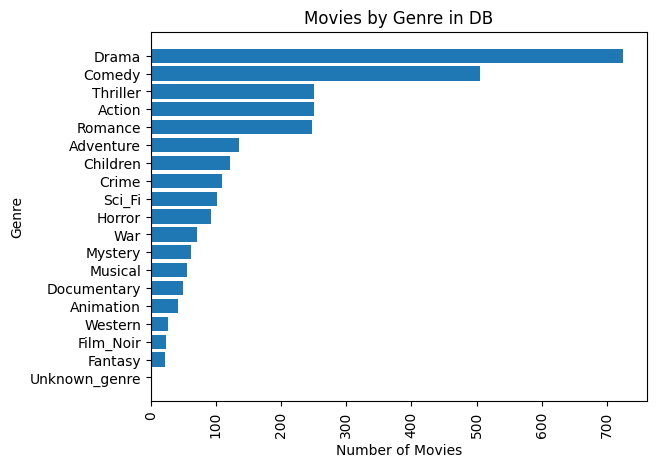

In [52]:
genre_counts = items.iloc[:,24-20:23].sum(axis=0).sort_values()

plt.barh(genre_counts.index, genre_counts.values)
plt.ylabel("Genre")
plt.xticks(rotation=90)
plt.xlabel("Number of Movies")
plt.title("Movies by Genre in DB")

Text(0.5, 1.0, 'Number of Ratings by Genre')

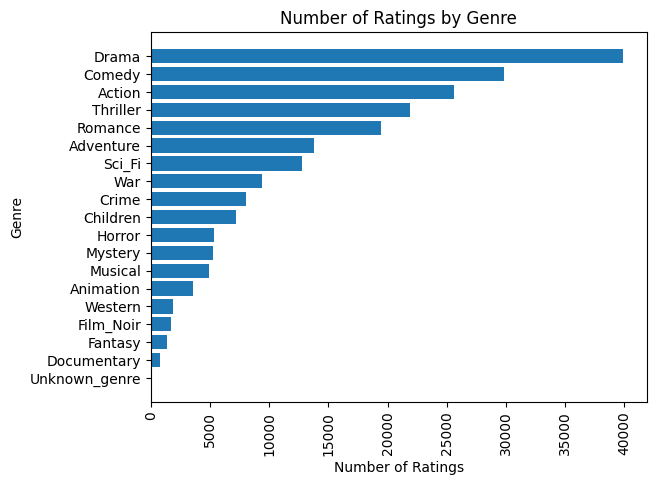

In [53]:

ratings_by_genre = merged_data[genres].sum(axis = 0).sort_values()

plt.barh(ratings_by_genre.index, ratings_by_genre.values)
plt.ylabel("Genre")
plt.xticks(rotation=90)
plt.xlabel("Number of Ratings")
plt.title("Number of Ratings by Genre")

### Ratings per Movie in DB

Ratings counts can be deceiving, since some genres are over-represented in the DB. Here I normalize the counts of rating.  War films seem to be be the most often rated genre of film given the number of each type of film is present in DB.

Text(0.5, 1.0, 'Number of Ratings (normalized by num of movies in DB)')

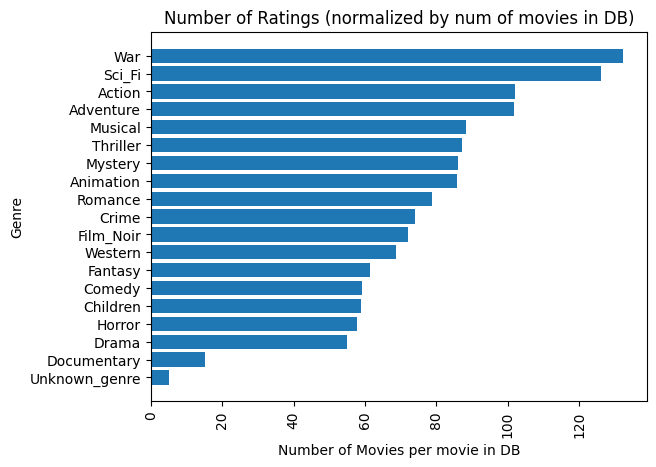

In [54]:
a = pd.DataFrame({"n_ratings": ratings_by_genre, "n_movies":  genre_counts})
a["ratings_normed"] = a.n_ratings / a.n_movies
a = a.sort_values("ratings_normed", ascending=True)

plt.barh(a.index, a.ratings_normed)
plt.ylabel("Genre")
plt.xticks(rotation=90)
plt.xlabel("Number of Movies per movie in DB")
plt.title("Number of Ratings (normalized by num of movies in DB)")

### Top 25 Most Reviewed Movies

In [55]:
merged_data.groupby(["movie_id", "movie_title"]).size().sort_values(ascending=False)[:25]

movie_id  movie_title                          
50        Star Wars                                583
258       Contact                                  509
100       Fargo                                    508
181       Return of the Jedi                       507
294       Liar Liar                                485
286       English Patient, The                     481
288       Scream                                   478
1         Toy Story                                452
300       Air Force One                            431
121       Independence Day (ID4)                   429
174       Raiders of the Lost Ark                  420
127       Godfather, The                           413
56        Pulp Fiction                             394
7         Twelve Monkeys                           392
98        Silence of the Lambs, The                390
237       Jerry Maguire                            384
117       Rock, The                                378
172       Empire 

### Top-ranked movies
As expected, those movies with with a mean score of 5.0 had only a few ratings.

In [56]:
merged_data.groupby(["movie_id", "movie_title"]).agg(
    num_rows=('rating', 'size'), 
    mean_value=('rating', 'mean')).sort_values(by = "mean_value", ascending=False)[:25].reset_index()

,movie_id,movie_title,num_rows,mean_value
0,1599,Someone Else's America,1,5.000000
1,814,"Great Day in Harlem, A",1,5.000000
2,1189,Prefontaine,3,5.000000
3,1653,Entertaining Angels: The Dorothy Day Story,1,5.000000
4,1293,Star Kid,3,5.000000
5,1500,Santa with Muscles,2,5.000000
6,1467,"Saint of Fort Washington, The",2,5.000000
7,1536,Aiqing wansui,1,5.000000
8,1122,They Made Me a Criminal,1,5.000000
9,1449,Pather Panchali,8,4.625000


## K-nearest neighbors model (original submission)

This is the original submission. The cells below contain modifications to the code to explore issues with imputed values.

I fit a basic k-nearest neighbors model on the user-item ranking matrix with all missing values imputed with $0$. I used the algorithm to find the nearest neighbors to the target user and then used a simple mean of the ratings to obtain predictions.

RMSE was determined for the target user based on the target user's ratings and those predicted by the above procedure.

In [57]:
N = 20
user_to_query = 5

ratings_matrix = users.pivot_table(index = "user",
                                   columns = "movie",
                                   values = "rating").fillna(0)

ratings_values = ratings_matrix.values

model = NearestNeighbors(n_neighbors = N,
                         metric = "cosine",
                         algorithm = "brute")

distances, indices = model.fit(ratings_values).kneighbors([ratings_values[user_to_query - 1]])

nearest_users = indices[0] + 1

# Target user's ratings
target_user_ratings = ratings_matrix.loc[user_to_query]

# Nearest neighbors ratings
neighbor_ratings = ratings_matrix.loc[nearest_users]

# Compute the predicted rating for each movie
# Here we assume simple arithmetic average of the k-nearest neighbors
# TODO: Consider doing a weighted average based on distance
# TODO: Figure out how to treat all the imputed 0s
predicted_ratings = neighbor_ratings.mean(axis = 0)

# Get predictions for movies not rated by target user
predictions = predicted_ratings[target_user_ratings == 0]

# Top 10 movie recommendations
top_10_movies = predictions.nlargest(10)
print("Top 10 Movie Recommendations for User " + str(user_to_query) + ":")
print(pd.DataFrame(top_10_movies).merge(items,
                                        how="left",
                                        left_on="movie",
                                        right_on="movie_id").iloc[:,0:3])

# Get target user's ratings and predicted ratings
rmse = np.round(math.sqrt(mean_squared_error(target_user_ratings[target_user_ratings != 0],
                                             predicted_ratings[target_user_ratings != 0])),
                2)
print(f"RMSE: {rmse}")

Top 10 Movie Recommendations for User 5:
      0  movie_id                 movie_title
0  3.90        96  Terminator 2: Judgment Day
1  3.70       195             Terminator, The
2  3.35       202               Groundhog Day
3  3.20       175                      Brazil
4  3.10        82               Jurassic Park
5  3.05         7              Twelve Monkeys
6  3.05       265   Hunt for Red October, The
7  2.95       184            Army of Darkness
8  2.95       746                 Real Genius
9  2.85        28                   Apollo 13
RMSE: 1.61


## K-nearest neighbors model, not including imputed ratings
### Approach 2

We want to consider the $N$ nearest neighbors who have ranked a movie, but only if the user is within a threshold of $K$ nearest neighbors, since we want to exclude ratings from users that are very dissimilar.

When making predictions, this approach ignores users who have not rated a movie (as opposed to using the imputed value of $0$).

Since we don't want to include users who are too far away from a user, we establish a threshold level $K$ for considering how far away to search for neighbors.

Then, to predict a rating, find the rating of up to the $N$ nearest neighbors who have ranked the target movie.  If there are not enough ratings, we use only those ratings that are present. For example, if $K=50$ and $N=10$ and if only $8$ users from the 50 nearest neighbors have ranked a movie, we consider only the $8$ ratings.

We assume, $K\ge N$

Return the the 10 movies with the highest predicted score.

In [58]:
# TODO: also have a minimum number of reviews 

# select about ~15% of users who are most similar to target user for the ratings pool
K = 150
MIN_NUM_RATINGS = 5
user_to_query = user_to_query

model_2 = NearestNeighbors(n_neighbors = K,
                         metric = "cosine",
                         algorithm = "brute")

distances, indices = model_2.fit(ratings_values).kneighbors([ratings_values[user_to_query - 1]])

# kneightbors returns 0-based index
# movies are 1-based indexed in the pd.dataframe
nearest_users = indices[0] + 1
neighbor_all_movies = ratings_matrix.loc[nearest_users]

# Get target's movies for prediction and testing
target_all_movies = ratings_matrix.loc[user_to_query]
target_unrated_movies = target_all_movies.loc[target_all_movies == 0]
target_rated_movies = target_all_movies.loc[target_all_movies != 0]

# Compute the predicted rating for each movie
# Find only non-zero ratings for each target movie
# distances are in ascending order
neighbor_ratings_full = pd.DataFrame({col: neighbor_all_movies.loc[:, col][neighbor_all_movies[col] != 0].tail(20) 
                                      for col in neighbor_all_movies.columns})

# Only include movies that have a certain number of neighbor ratings
valid_movie_ratings = neighbor_ratings_full.loc[:, neighbor_ratings_full.count(axis = 0) >= MIN_NUM_RATINGS]

movies_to_predict = list(set(target_unrated_movies.index) & set(valid_movie_ratings.columns))
predicted_ratings = valid_movie_ratings.loc[:, movies_to_predict].mean(skipna = True,
                                          axis = 0)
predicted_ratings.index.name = "movie"

# Top 10 movie recommendations
top_10_movies = predicted_ratings.nlargest(10)
print("Top 10 Movie Recommendations for User " + str(user_to_query) + ":")
print(pd.DataFrame(top_10_movies).merge(items,
                                        how="left",
                                        left_on="movie",
                                        right_on="movie_id").iloc[:,0:3])

# Find the intersection of target's rated movies and valid predicted movies
rmse_movies = list(set(valid_movie_ratings.columns) & set(target_rated_movies.index))
rmse = np.round(math.sqrt(mean_squared_error(target_all_movies[rmse_movies],
                                             valid_movie_ratings.loc[:, rmse_movies].mean(skipna=True,
                                                                                          axis = 0))),
                                             2)
print(f"RMSE: {rmse}")

Top 10 Movie Recommendations for User 5:
      0  movie_id                                        movie_title
0  4.80       114    Wallace & Gromit: The Best of Aardman Animation
1  4.75       963                   Some Folks Call It a Sling Blade
2  4.65       480                                 North by Northwest
3  4.60        64                          Shawshank Redemption, The
4  4.60       474  Dr. Strangelove or: How I Learned to Stop Worr...
5  4.60      1269                              Love in the Afternoon
6  4.55       178                                       12 Angry Men
7  4.55       479                                            Vertigo
8  4.50       482                                   Some Like It Hot
9  4.50       483                                         Casablanca
RMSE: 1.23


### Normalize the Data
Try collaborative filtering with normalized (e.g., mean-centered) data.

In [59]:
ratings_matrix_2 = users.pivot_table(index = "user",
                                   columns = "movie",
                                   values = "rating")

user_mean_ratings = ratings_matrix_2.mean(axis = 1,
                                          skipna = True)
normed_matrix = ratings_matrix_2 - user_mean_ratings
normed_matrix = normed_matrix.fillna(0)

### Model with normalized data with imputed values

In [60]:
N = 20
user_to_query = user_to_query
user_mean = user_mean_ratings[user_to_query]

data = normed_matrix

model_3 = NearestNeighbors(n_neighbors = N,
                         metric = "cosine",
                         algorithm = "brute")

distances, indices = model_3.fit(data).kneighbors(data.loc[[user_to_query]])

nearest_users = indices[0] + 1

target_user_ratings = data.loc[user_to_query]

# Nearest neighbors ratings
neighbor_ratings = data.loc[nearest_users]
predicted_ratings = neighbor_ratings.mean(axis = 0)

# Predict unrated users using the above mask
predictions = predicted_ratings.loc[target_user_ratings == 0] + user_mean
predictions.index.name = "movie"

# Top 10 movie recommendations
top_10_movies = predictions.nlargest(10)
print("Top 10 Movie Recommendations for User " + str(user_to_query) + ":")
print(pd.DataFrame(top_10_movies).merge(items,
                                        how="left",
                                        left_on="movie",
                                        right_on="movie_id").iloc[:,0:3])

rated_predictions = predicted_ratings[target_user_ratings != 0]

rmse = np.round(math.sqrt(mean_squared_error(target_user_ratings[target_user_ratings != 0],
                                             rated_predictions)), 2)
print(f"RMSE: {rmse}")

Top 10 Movie Recommendations for User 5:
          0  movie_id                movie_title
0  3.564286       202              Groundhog Day
1  3.528192        22                 Braveheart
2  3.476369       195            Terminator, The
3  3.459031       483                 Casablanca
4  3.452536        64  Shawshank Redemption, The
5  3.450353       268                Chasing Amy
6  3.434067       655                Stand by Me
7  3.417143       302          L.A. Confidential
8  3.405320       161                    Top Gun
9  3.399286       685         Executive Decision
RMSE: 1.31
